In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Objectif :** Prédire si une personne est infectée du covid 19 avec f1>80%


# 1. Exploration des données 

## Checklist

### Analyse de forme
- **Variable target :** SARS-Cov-2 exam result (negative/positive)
- **Nombre de lignes/colonnes :** 5644 lignes et 111 colonnes, 1 colonne d'ID
- **Type des variables :** 70 variables continues, 4 variables entières et 37 variables qualitatives
- **Analyse des variables manquantes :** Beaucoup de NaN, groupe à 76% de NaN : tests viraux, groupe à 89% : tests sanguins 

### Analyse de fond
Suppression des variables avec + de 90% de NaN et suppression de la variable 'Patient ID'
- **Analyse de la variable target :** negative : 90,11% et positive : 9,88%
- **Signification des variables :** Tests sanguins, viraux, détection de maladies ...
- **Visualisation des variables :** 
    - données continues : Données centrées en 0 et réduites, la plupart des valeurs semblent suivre une distribution normale. Parfois la distribution est asymétrique
    - données entières : Pour l'âge, c'est peut être par paquet de 5 et la distribution est globalement uniforme. Pour les variables d'admission à l'hôpital, c'est du binaire 0-1
    - données qualitatives : positive/negative pour 3 variables ou detected/not detected pour le reste. Globalement negative/not detected est majoritaire sauf pour Rhinovirus/Enterovirus ou detected est à plus de 25%. **La variable Parainfluenza 2 n'a que le label non detected donc il faut la supprimer**
- **Relations variables/target :**
    - **Tests sanguins/target :** La répartition des valeurs pour les variables Platelets, Leukocytes , Monocytes semble être significativement différente (moyenne différentes)
    - **Age/target :** La répartition des détectés positifs semble être uniforme au dela du 4ème quantile. Il y a presque aucun détecté positif pour 0 <= quantile <=3
    - **Tests viraux/target :** RAS, beaucoup de détections de Rhinovirus/Enterovirus sans lien avec le covid 19, peu de personnes ont deux virus en même temps
- **Autres relations :**
    - **Age/tests sanguins :** Pas vraiment de corrélation (max 0.28)
    - **Tests sanguins/tests sanguins :** Corrélation hermatocrit - hemoglobin >0.9 et mean corpuscular hemoglobin - mearn corpuscular volume >0.8
    - **Tests viraux/tests viraux rapides :** Les tests rapides sont moins précis (plus sensibles) que les tests normaux et on le voit ici lorsque le test rapide détecte positif/non positif alors que le test normal a detecté l'inverse. On préfère faire confiance au test classique et **on supprime donc les variables de test rapide**
    - **Malade/tests sanguins :** Entre 0 et 3 maladies ont été détectées chez les individus **(création de la colonne Malade)**. Les taux de lymphocytes sont différents si la personne est détectée malade ou non. Les taux sanguins sont différents si la personne est positive au covid 19 ou positive à une autre maladie
    - **Hospitalisation/tests sanguins :** **Création de la colonne Statut** qui regroupe les 3 colonnes de soins, **on peut donc les supprimer**. Taux de lymphocytes et leukocytes différents lorsque l'individu est en soins intensifs
    - **Hospitalisation/malade :** ~1/8 des patients positifs à d'autres maladies que le covid 19 sont admis en soins à l'hôpital
- **Analyse approfondie des NaN :**
    - Data après dropna() : **362 individus**, tests sanguins apres dropna() : **598 individus** et tests viraux après dropna() : **1352 individus**
    - **Target après dropna() :** La proportion de négatifs ne change pas drastiquement
        - sang/viral dropna() 312neg 50pos - 86% 14%
        - sang dropna() 517neg 81pos - 86% 14%
        - viral dropna() - 1240neg 112pos - 92% 8%
- **Tests d'hypothèses :**
    - **H0** : Les taux sanguins des individus positifs au covid 19 ne sont pas différents de ceux négatifs
        - **Hemoglobin, Platelets, Red blood Cells, Leukocytes, Eosinophils, Monocytes** ont des moyennes significativement différentes selon que le patient est positif/négatif au covid 19 pour le niveau $\alpha_{\text{bonf}} = \dfrac{0.05}{14}$

In [2]:
data = pd.read_excel('dataset.xlsx')

In [3]:
pd.set_option('display.max_column', 111)
data

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## Analyse de forme

In [4]:
df = data.copy()

### Taille du dataset

In [5]:
df.shape

(5644, 111)

### Type des colonnes

In [6]:
pd.set_option('display.max_row', 111)
df.dtypes

Patient ID                                                object
Patient age quantile                                       int64
SARS-Cov-2 exam result                                    object
Patient addmited to regular ward (1=yes, 0=no)             int64
Patient addmited to semi-intensive unit (1=yes, 0=no)      int64
Patient addmited to intensive care unit (1=yes, 0=no)      int64
Hematocrit                                               float64
Hemoglobin                                               float64
Platelets                                                float64
Mean platelet volume                                     float64
Red blood Cells                                          float64
Lymphocytes                                              float64
Mean corpuscular hemoglobin concentration (MCHC)         float64
Leukocytes                                               float64
Basophils                                                float64
Mean corpuscular hemoglob

In [7]:
df.dtypes.value_counts()

float64    70
object     37
int64       4
dtype: int64

### Analyse des NaN

<AxesSubplot:>

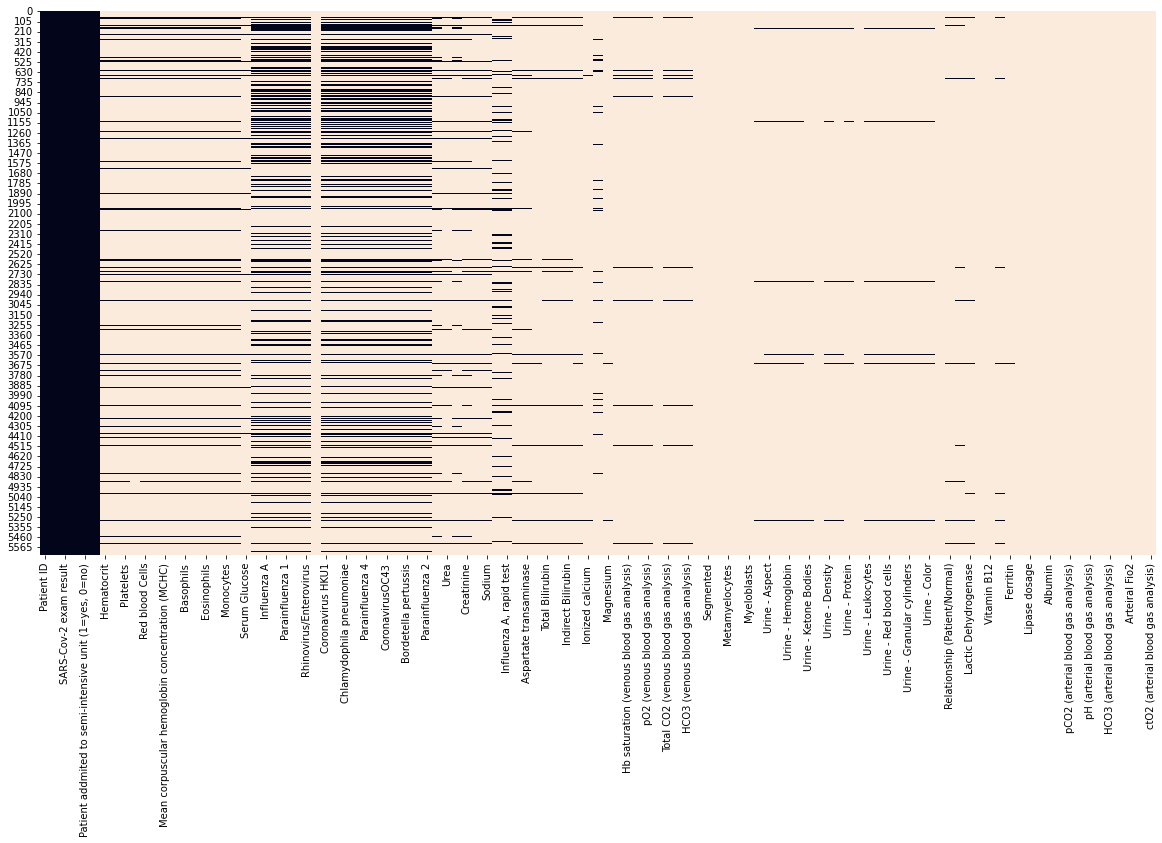

In [8]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [9]:
(df.isna().sum(axis=0)/df.shape[0]).sort_values(ascending=False)

Urine - Sugar                                            1.000000
Mycoplasma pneumoniae                                    1.000000
Partial thromboplastin time (PTT)                        1.000000
Prothrombin time (PT), Activity                          1.000000
D-Dimer                                                  1.000000
Fio2 (venous blood gas analysis)                         0.999823
Urine - Nitrite                                          0.999823
Vitamin B12                                              0.999468
Lipase dosage                                            0.998583
Albumin                                                  0.997697
Phosphor                                                 0.996456
Arteiral Fio2                                            0.996456
Ferritin                                                 0.995925
Arterial Lactic Acid                                     0.995216
ctO2 (arterial blood gas analysis)                       0.995216
Hb saturat

## Analyse de fond

### Supression des variables inutiles

In [10]:
df = df[df.columns[(df.isna().sum()/df.shape[0]) <0.9]]
df

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,ae66feb9e4dc3a0,3,positive,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,517c2834024f3ea,17,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,5c57d6037fe266d,4,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,c20c44766f28291,10,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

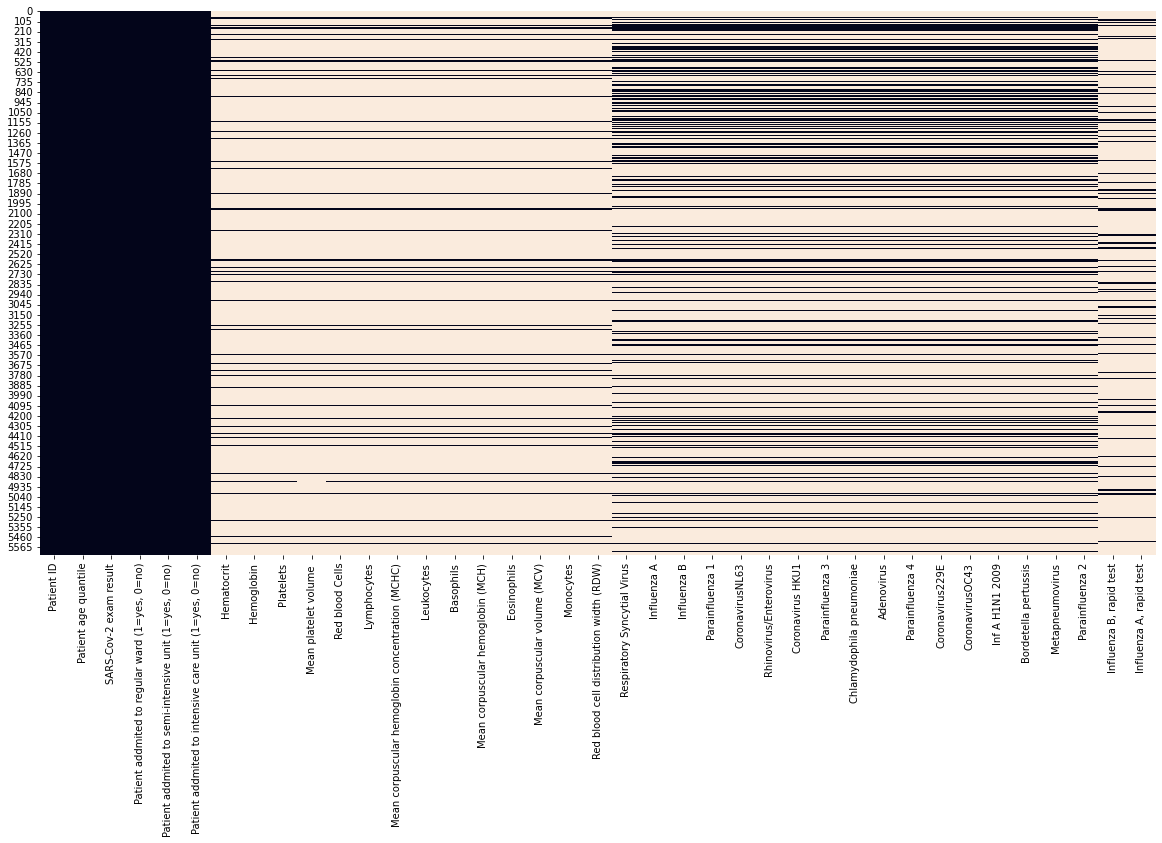

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [12]:
df = df.drop('Patient ID',axis=1)
df

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
0,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
2,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,positive,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,17,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,4,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,10,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analyse de la variable target


In [13]:
df["SARS-Cov-2 exam result"].value_counts(normalize=True)

negative    0.901134
positive    0.098866
Name: SARS-Cov-2 exam result, dtype: float64

### Histogramme des variables continues

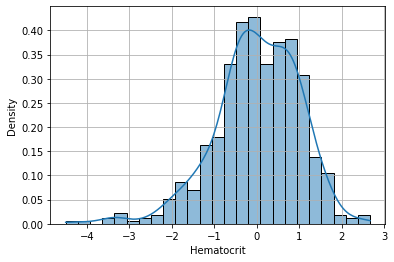

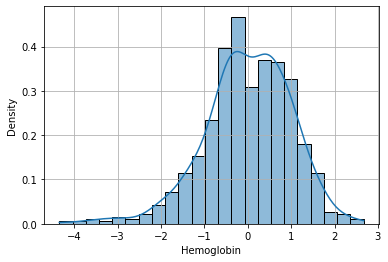

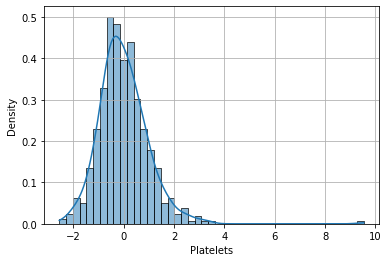

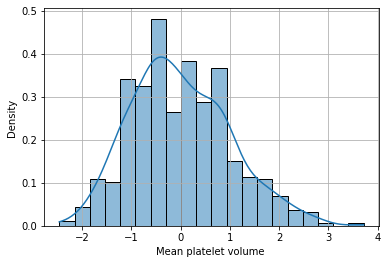

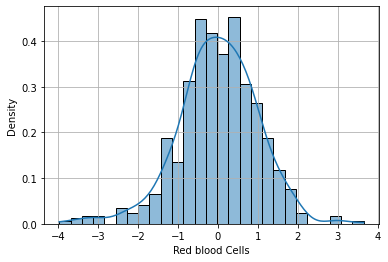

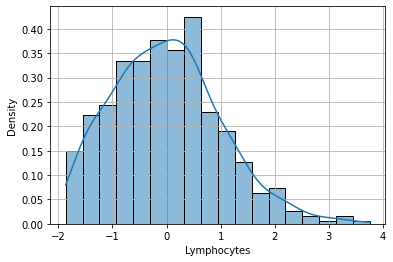

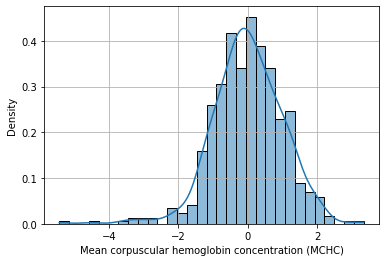

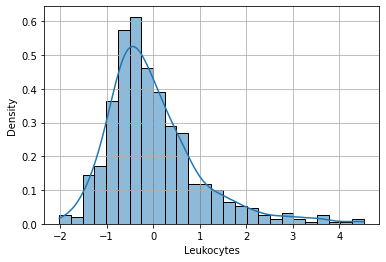

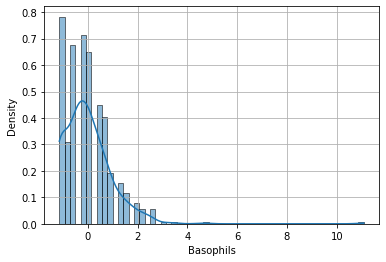

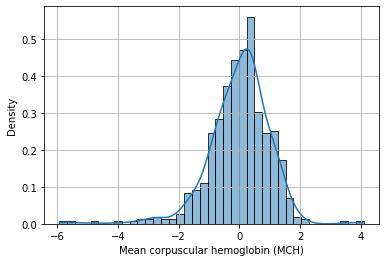

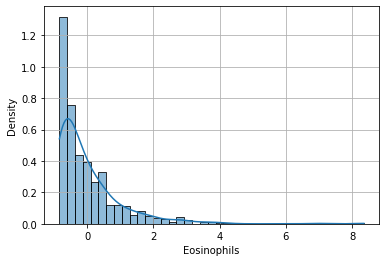

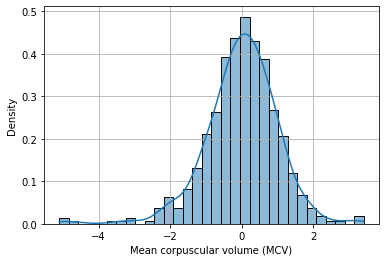

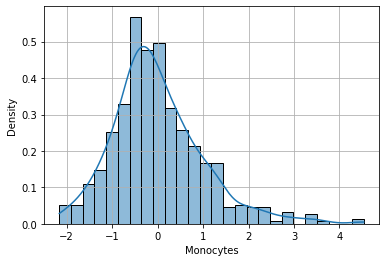

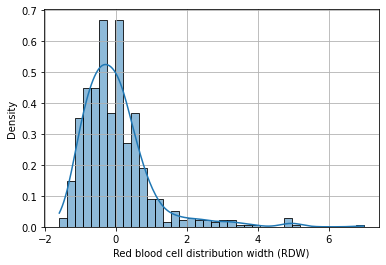

In [14]:
for col in df.columns[df.dtypes == "float64"]:
    plt.figure()
    sns.histplot(df[col], kde=True, stat='density')
    plt.grid()
    plt.show()

### Histogramme de la variable age

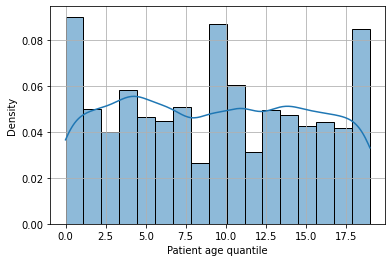

In [15]:
plt.figure()
sns.histplot(df["Patient age quantile"], kde=True, stat='density')
plt.grid()
plt.show()

### Données qualitatives

In [16]:
for col in df[df.columns[df.dtypes == 'object']].columns:
    print(f'{col :-<50} {df[col].unique()}')

SARS-Cov-2 exam result---------------------------- ['negative' 'positive']
Respiratory Syncytial Virus----------------------- [nan 'not_detected' 'detected']
Influenza A--------------------------------------- [nan 'not_detected' 'detected']
Influenza B--------------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 1----------------------------------- [nan 'not_detected' 'detected']
CoronavirusNL63----------------------------------- [nan 'not_detected' 'detected']
Rhinovirus/Enterovirus---------------------------- [nan 'detected' 'not_detected']
Coronavirus HKU1---------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 3----------------------------------- [nan 'not_detected' 'detected']
Chlamydophila pneumoniae-------------------------- [nan 'not_detected' 'detected']
Adenovirus---------------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 4----------------------------------- [nan 'not_detected' 'detected']
Coronavirus2

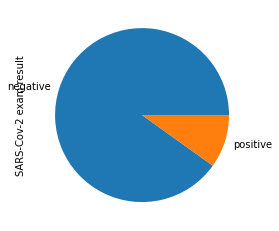

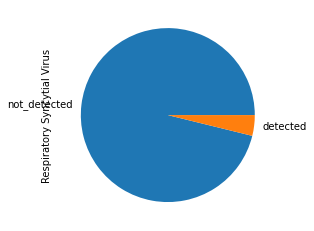

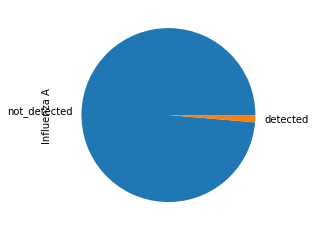

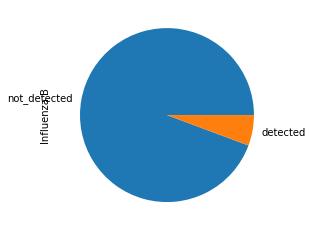

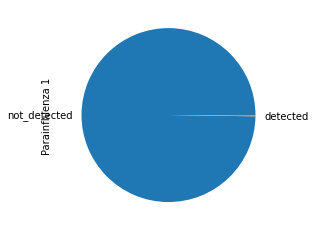

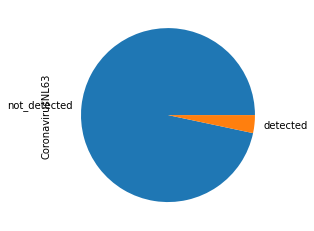

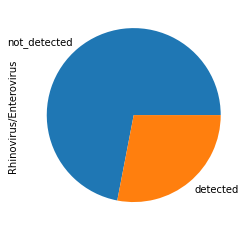

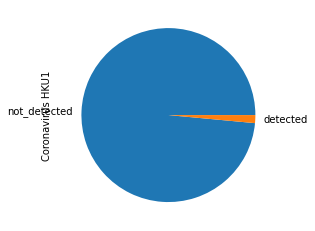

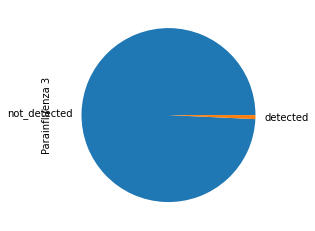

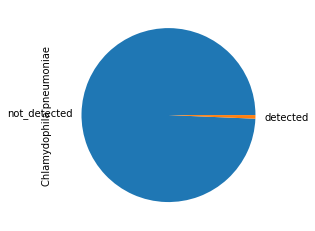

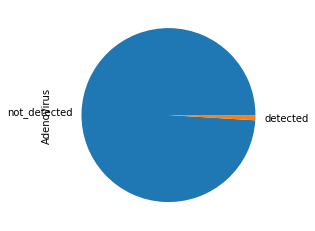

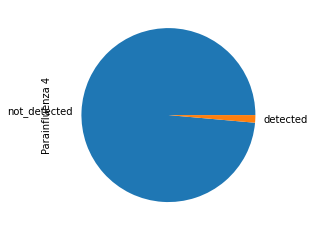

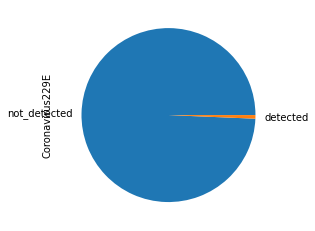

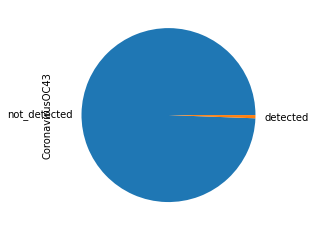

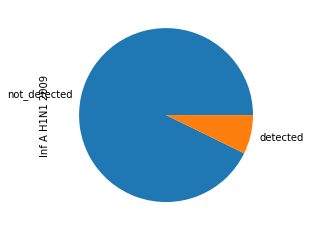

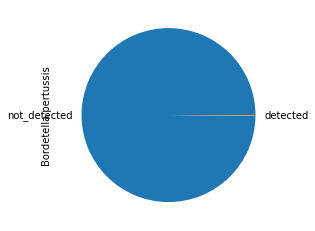

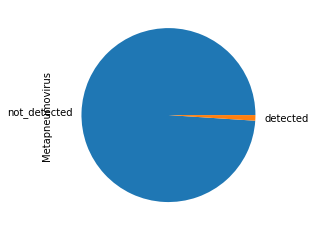

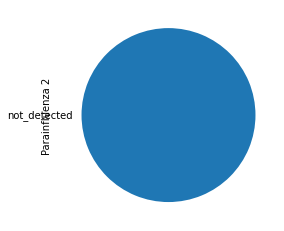

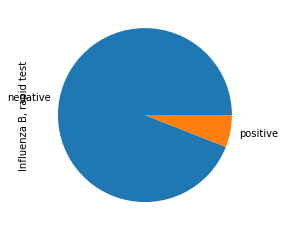

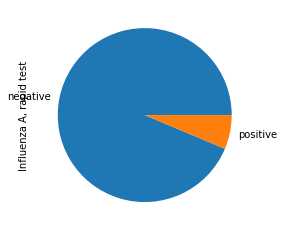

In [17]:
for col in df[df.columns[df.dtypes == 'object']].columns:
    plt.figure()
    df[col].value_counts().plot.pie()

In [18]:
df = df.drop('Parainfluenza 2',axis=1)

### Relations variables/target

In [19]:
positive_df = df[df['SARS-Cov-2 exam result'] == 'positive']
negative_df = df[df['SARS-Cov-2 exam result'] == 'negative']

In [20]:
missing = df.isna().sum()/df.shape[0]
tests_viraux = df.columns[(missing > 0.75) & (missing < 0.86)]
tests_sanguins = df.columns[(missing > 0.86) & (missing < 0.9)]

#### Tests sanguins/target

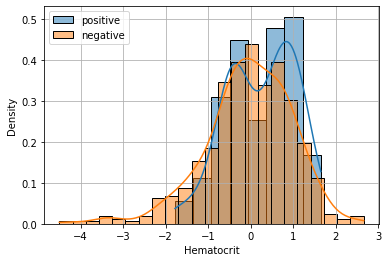

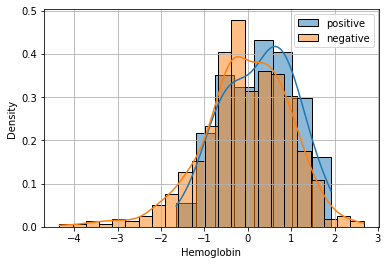

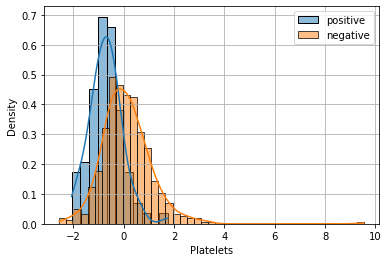

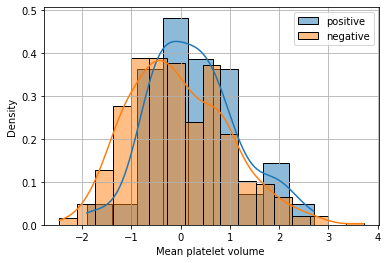

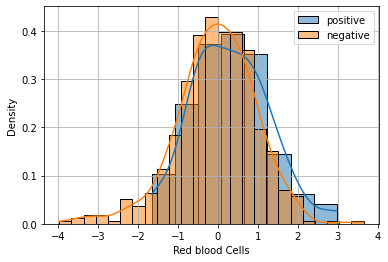

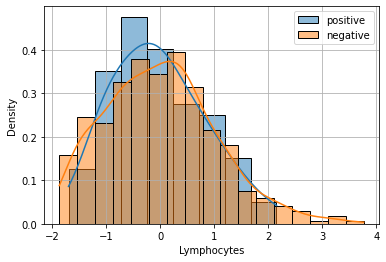

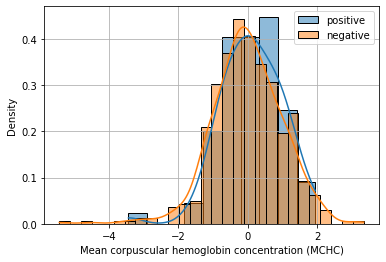

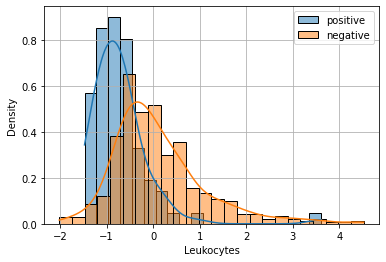

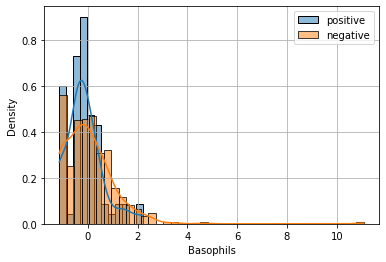

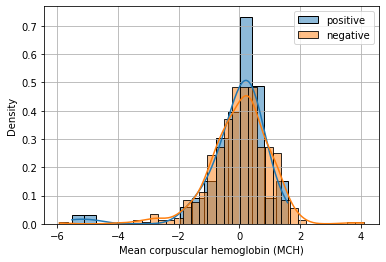

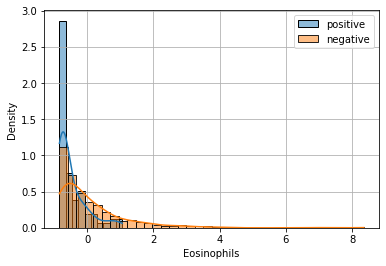

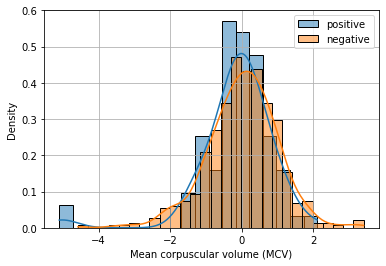

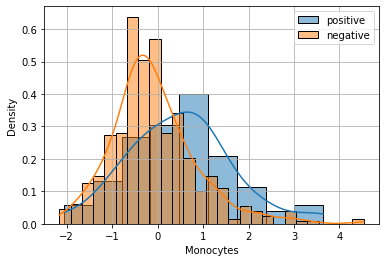

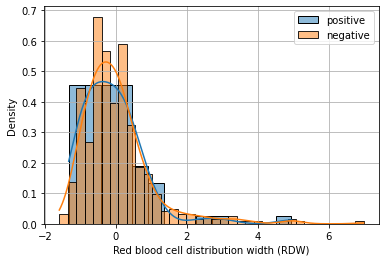

In [21]:
for col in tests_sanguins:
    plt.figure()
    sns.histplot(positive_df[col], kde=True, stat='density', label='positive')
    sns.histplot(negative_df[col], kde=True, stat='density', label='negative')
    plt.grid()
    plt.legend()
    plt.show()

#### Age/target

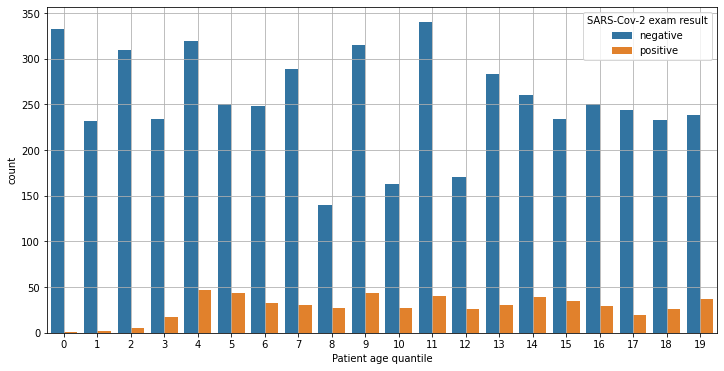

In [22]:
plt.figure(figsize=(12,6))
sns.countplot(x='Patient age quantile', hue='SARS-Cov-2 exam result', data=df)
plt.grid()
plt.show()

#### Tests viraux/target

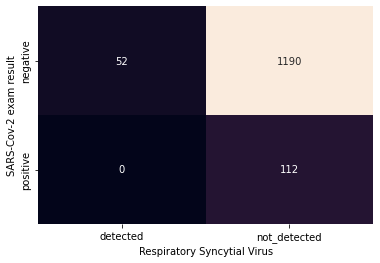

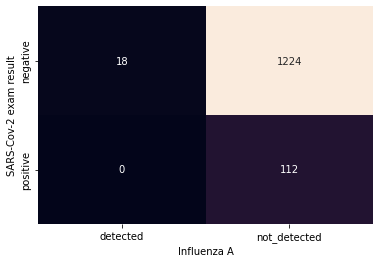

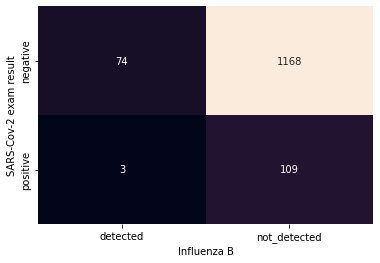

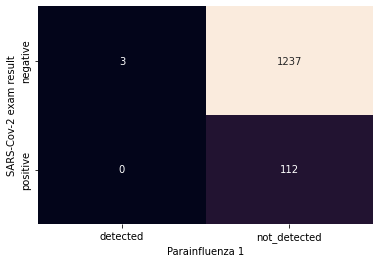

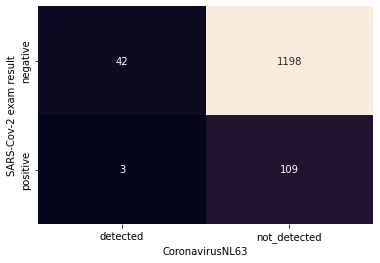

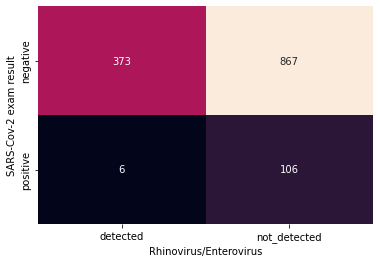

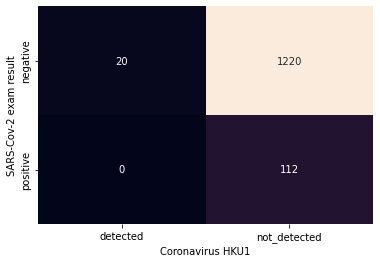

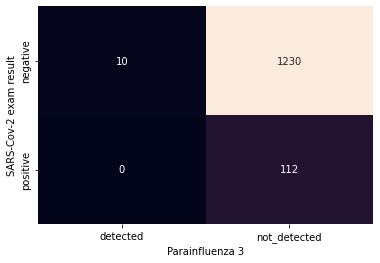

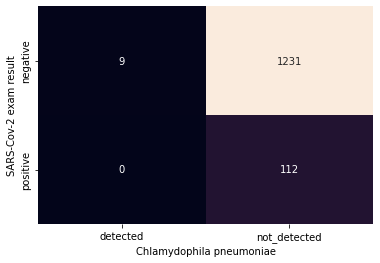

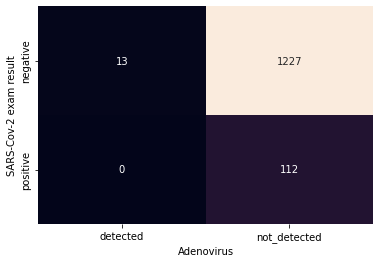

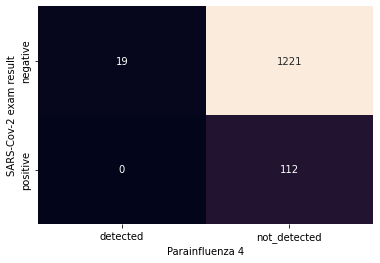

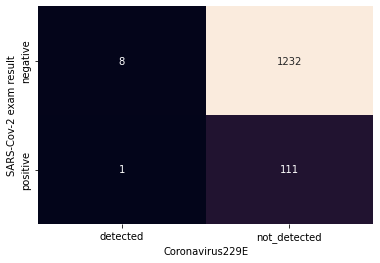

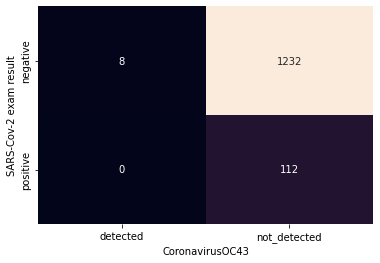

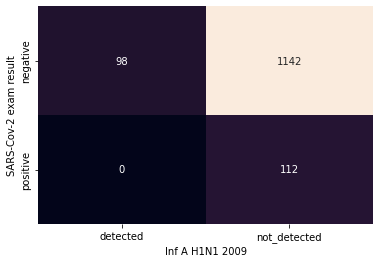

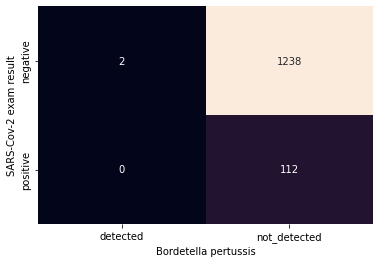

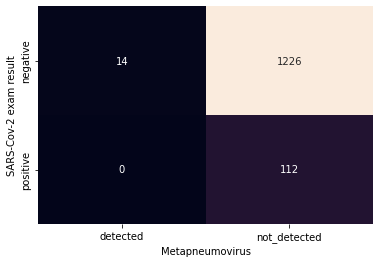

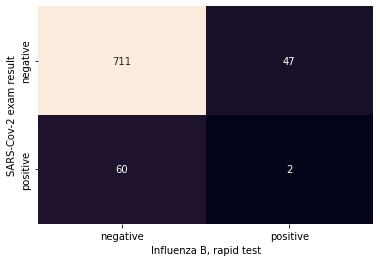

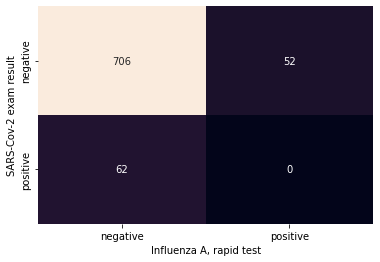

In [23]:
for col in tests_viraux:
    plt.figure()
    sns.heatmap(pd.crosstab(df['SARS-Cov-2 exam result'], df[col]), fmt='d', annot=True, cbar=False)
    plt.show()

### Autres relations

#### Age/tests sanguins

In [24]:
df.corr()['Patient age quantile'].sort_values(ascending=False)


Patient age quantile                                     1.000000
Mean corpuscular volume (MCV)                            0.281655
Mean corpuscular hemoglobin (MCH)                        0.197394
Red blood cell distribution width (RDW)                  0.166429
Mean platelet volume                                     0.119449
Basophils                                                0.107525
Hematocrit                                               0.096808
Hemoglobin                                               0.060320
Monocytes                                                0.050962
Patient addmited to regular ward (1=yes, 0=no)           0.046166
Eosinophils                                              0.022085
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.015736
Patient addmited to intensive care unit (1=yes, 0=no)   -0.035772
Red blood Cells                                         -0.037510
Mean corpuscular hemoglobin concentration (MCHC)        -0.124671
Lymphocyte

#### Tests sanguins/tests sanguins

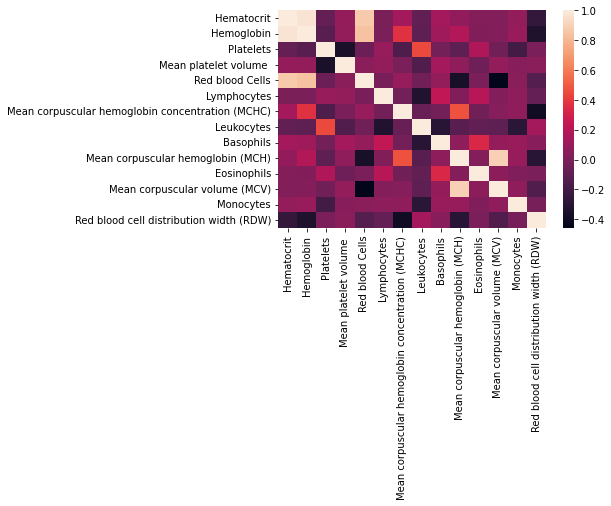

In [25]:
plt.figure()
sns.heatmap(df[tests_sanguins].corr())
plt.show()

#### Tests viraux/tests viraux

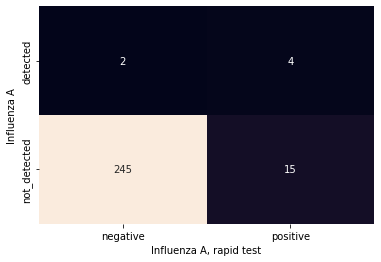

In [26]:
plt.figure()
sns.heatmap(pd.crosstab(df['Influenza A'], df['Influenza A, rapid test']), fmt='d', annot=True, cbar=False)
plt.show()

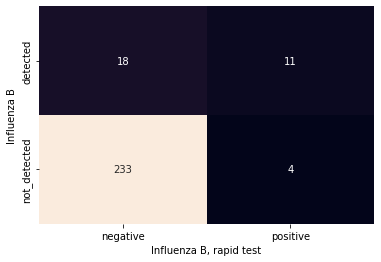

In [27]:
plt.figure()
sns.heatmap(pd.crosstab(df['Influenza B'], df['Influenza B, rapid test']), fmt='d', annot=True, cbar=False)
plt.show()

In [28]:
df = df.drop(['Influenza B, rapid test', 'Influenza A, rapid test'],axis = 1)

#### Malade/tests sanguins

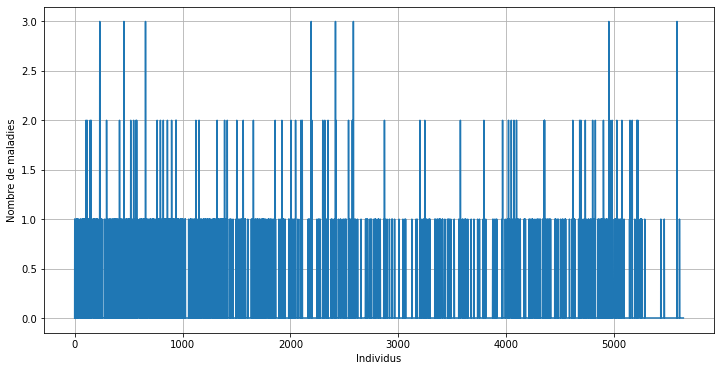

In [29]:
plt.figure(figsize=(12,6))
(df[tests_viraux[:-2]] == 'detected').sum(axis=1).plot()
plt.xlabel('Individus')
plt.ylabel('Nombre de maladies')
plt.grid()
plt.show()

In [30]:
df['Malade'] = (df[tests_viraux[:-2]] == 'detected').sum(axis=1) >= 1

In [31]:
df

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Malade
0,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,True
2,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,positive,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5640,17,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5641,4,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5642,10,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [32]:
malade_df = df[df['Malade'] == True]
non_malade_df = df[df['Malade'] == False]

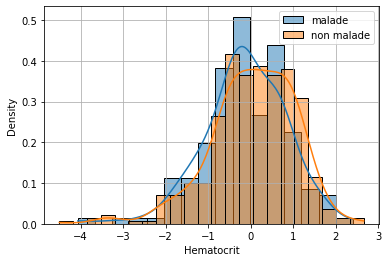

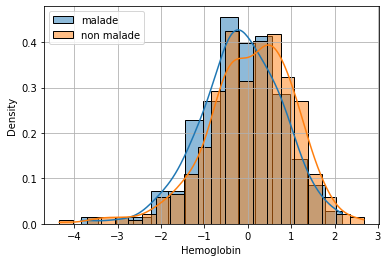

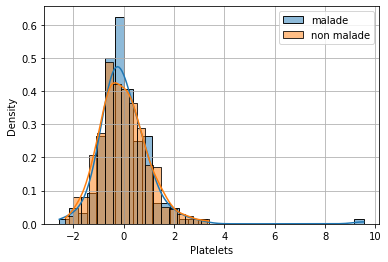

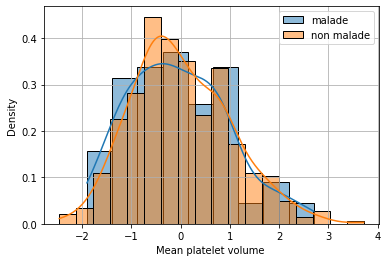

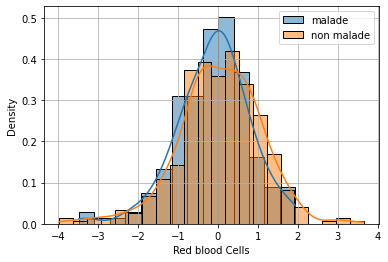

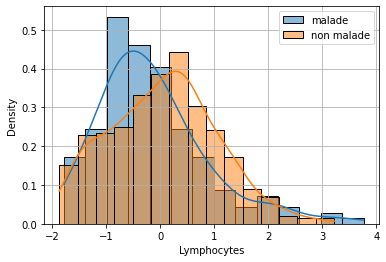

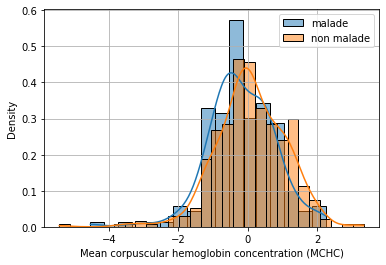

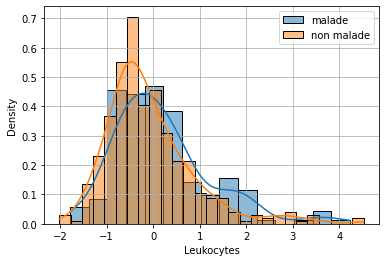

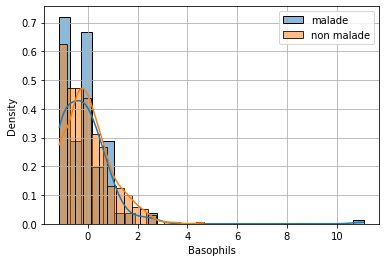

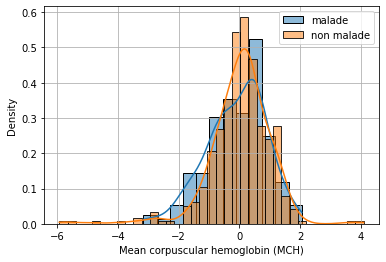

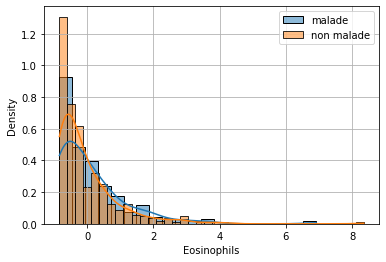

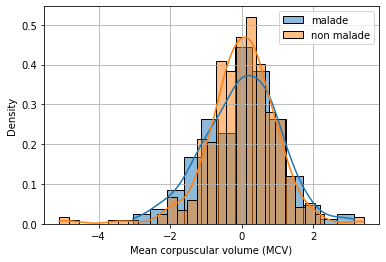

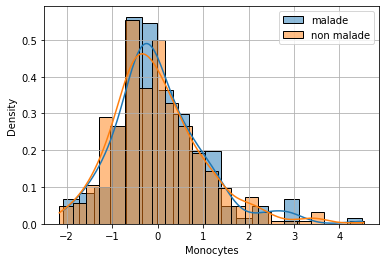

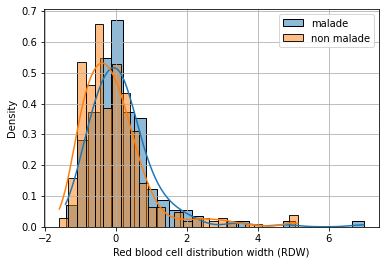

In [33]:
for col in tests_sanguins:
    plt.figure()
    sns.histplot(malade_df[col], kde=True, stat='density', label='malade')
    sns.histplot(non_malade_df[col], kde=True, stat='density', label='non malade')
    plt.grid()
    plt.legend()
    plt.show()

#### Hospitalisation/tests sanguins

In [34]:
def Hospitalisation(row):
    if row['Patient addmited to regular ward (1=yes, 0=no)'] == 1:
        return('surveillance')
    elif row['Patient addmited to semi-intensive unit (1=yes, 0=no)'] == 1:
        return('soins semi-intensifs')
    elif row['Patient addmited to intensive care unit (1=yes, 0=no)'] == 1:
        return('soins intensifs')
    else:
        return('inconnu')

In [35]:
df['Statut'] = df.apply(Hospitalisation, axis = 1)
df

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Malade,Statut
0,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
1,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,True,inconnu
2,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
3,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
4,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,True,inconnu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,positive,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
5640,17,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
5641,4,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
5642,10,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu


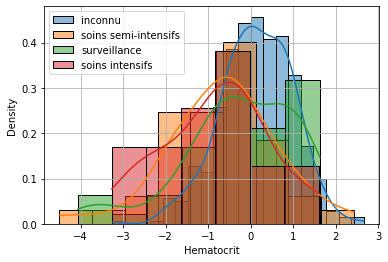

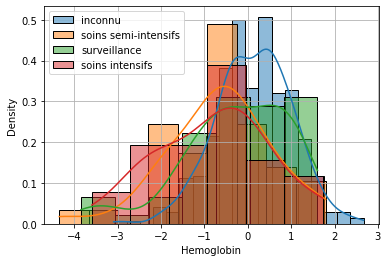

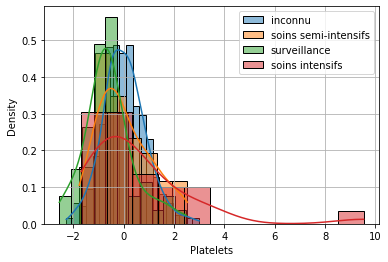

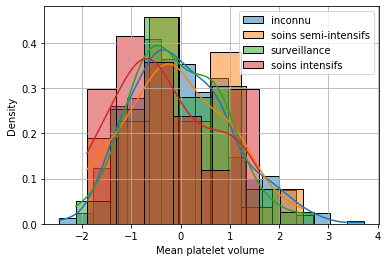

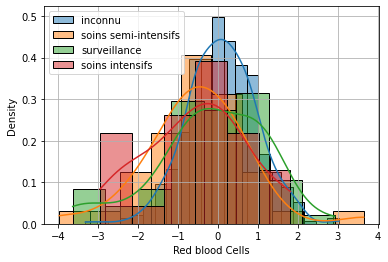

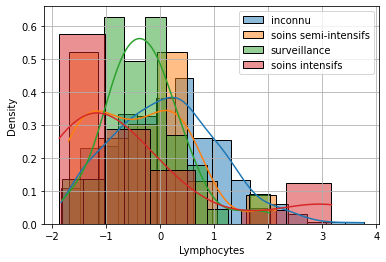

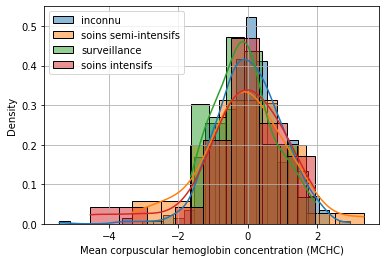

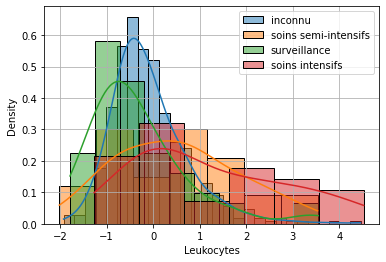

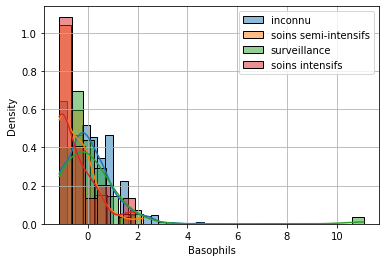

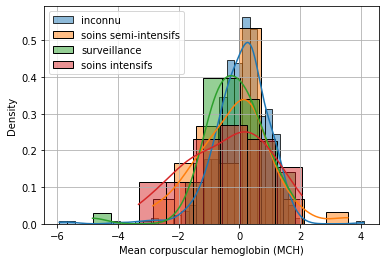

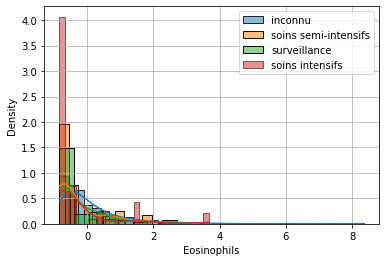

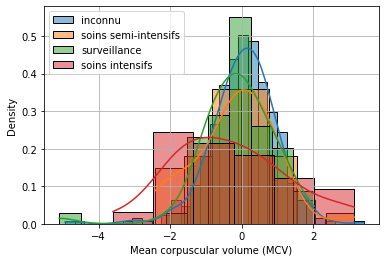

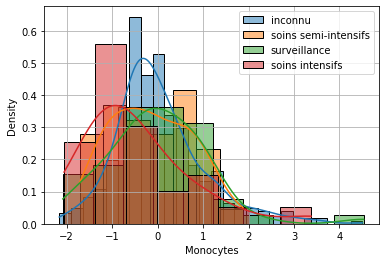

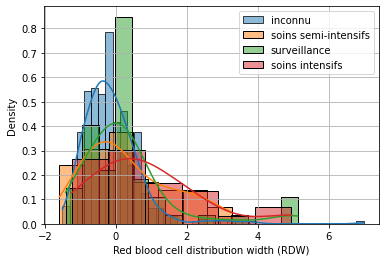

In [36]:
for col in tests_sanguins:
    plt.figure()
    for cat in df['Statut'].unique():
        sns.histplot(df[df['Statut'] == cat][col], kde=True, stat='density', label=cat)
    plt.grid()
    plt.legend()
    plt.show()

#### Hospitalisation/malade

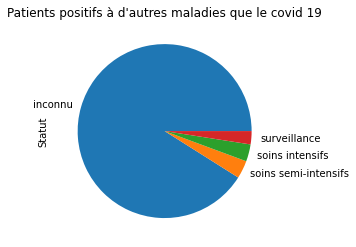

inconnu                 630
soins semi-intensifs     23
soins intensifs          22
surveillance             17
Name: Statut, dtype: int64


In [37]:
plt.figure()
df[(df['Malade'] == True)]['Statut'].value_counts().plot.pie()
plt.title("Patients positifs à d'autres maladies que le covid 19")
plt.show()
print(df[(df['Malade'] == True)]['Statut'].value_counts())

### Analyse approfondie des NaN

In [38]:
df.dropna().count()

Patient age quantile                                     362
SARS-Cov-2 exam result                                   362
Patient addmited to regular ward (1=yes, 0=no)           362
Patient addmited to semi-intensive unit (1=yes, 0=no)    362
Patient addmited to intensive care unit (1=yes, 0=no)    362
Hematocrit                                               362
Hemoglobin                                               362
Platelets                                                362
Mean platelet volume                                     362
Red blood Cells                                          362
Lymphocytes                                              362
Mean corpuscular hemoglobin concentration (MCHC)         362
Leukocytes                                               362
Basophils                                                362
Mean corpuscular hemoglobin (MCH)                        362
Eosinophils                                              362
Mean corpuscular volume 

In [39]:
df[tests_sanguins].dropna().count()

Hematocrit                                          598
Hemoglobin                                          598
Platelets                                           598
Mean platelet volume                                598
Red blood Cells                                     598
Lymphocytes                                         598
Mean corpuscular hemoglobin concentration (MCHC)    598
Leukocytes                                          598
Basophils                                           598
Mean corpuscular hemoglobin (MCH)                   598
Eosinophils                                         598
Mean corpuscular volume (MCV)                       598
Monocytes                                           598
Red blood cell distribution width (RDW)             598
dtype: int64

In [40]:
df[tests_viraux[:-2]].dropna().count()

Respiratory Syncytial Virus    1352
Influenza A                    1352
Influenza B                    1352
Parainfluenza 1                1352
CoronavirusNL63                1352
Rhinovirus/Enterovirus         1352
Coronavirus HKU1               1352
Parainfluenza 3                1352
Chlamydophila pneumoniae       1352
Adenovirus                     1352
Parainfluenza 4                1352
Coronavirus229E                1352
CoronavirusOC43                1352
Inf A H1N1 2009                1352
Bordetella pertussis           1352
Metapneumovirus                1352
dtype: int64

#### Target après dropna

In [41]:
df.dropna()['SARS-Cov-2 exam result'].value_counts(normalize=True)

negative    0.861878
positive    0.138122
Name: SARS-Cov-2 exam result, dtype: float64

In [42]:
df_a = df[tests_sanguins]
df_a['SARS-Cov-2 exam result'] = df['SARS-Cov-2 exam result']
df_a.dropna()['SARS-Cov-2 exam result'].value_counts(normalize=True)

c:\users\jmv\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


negative    0.864548
positive    0.135452
Name: SARS-Cov-2 exam result, dtype: float64

In [43]:
df_b = df[tests_viraux[:-2]]
df_b['SARS-Cov-2 exam result'] = df['SARS-Cov-2 exam result']
df_b.dropna()['SARS-Cov-2 exam result'].value_counts(normalize=True)

c:\users\jmv\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


negative    0.91716
positive    0.08284
Name: SARS-Cov-2 exam result, dtype: float64

### Test d'hypothèse

#### H0 : Les taux sanguins des individus positifs au covid 19 ne sont pas différents de ceux négatifs

In [44]:
from scipy.stats import ttest_ind
for col in tests_sanguins:
    row1 = df[df['SARS-Cov-2 exam result'] == 'positive'][col].dropna()
    row2 =  df[df['SARS-Cov-2 exam result'] == 'negative'][col].dropna()
    stat, pval = ttest_ind(row1, row2, equal_var= False)
    alpha = 0.05
    alpha_bonf = alpha/len(tests_sanguins)
    if pval < alpha_bonf:
        print(f'{col:-<50} H0 rejetée')
    else:
        print(f'{col:-<50} 0')

Hematocrit---------------------------------------- 0
Hemoglobin---------------------------------------- H0 rejetée
Platelets----------------------------------------- H0 rejetée
Mean platelet volume ----------------------------- 0
Red blood Cells----------------------------------- H0 rejetée
Lymphocytes--------------------------------------- 0
Mean corpuscular hemoglobin concentration (MCHC)-- 0
Leukocytes---------------------------------------- H0 rejetée
Basophils----------------------------------------- 0
Mean corpuscular hemoglobin (MCH)----------------- 0
Eosinophils--------------------------------------- H0 rejetée
Mean corpuscular volume (MCV)--------------------- 0
Monocytes----------------------------------------- H0 rejetée
Red blood cell distribution width (RDW)----------- 0


In [45]:
df = df.drop(['Patient addmited to regular ward (1=yes, 0=no)', 
             'Patient addmited to semi-intensive unit (1=yes, 0=no)',
             'Patient addmited to intensive care unit (1=yes, 0=no)'],axis=1)

# 2. Pre-processing des données

In [46]:
tests_viraux = tests_viraux[:-2]

In [47]:
tests_sanguins

Index(['Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ',
       'Red blood Cells', 'Lymphocytes',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Leukocytes',
       'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils',
       'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)'],
      dtype='object')

In [48]:
df1 = df.copy()
new_cols = ['Malade', 'Statut']
key_cols = ['Patient age quantile', 'SARS-Cov-2 exam result']
df1 = df1[key_cols + list(tests_sanguins) + new_cols]
#df1['Malade'] = df1['Malade'].replace({True: 'Oui', False: 'Non'})
df1

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Malade,Statut
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
1,17,negative,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,True,inconnu
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,inconnu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
5640,17,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
5641,4,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu
5642,10,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,inconnu


In [49]:
from sklearn.model_selection import train_test_split
training_set, testing_set = train_test_split(df1, test_size = 0.2, random_state = 0)

In [50]:
print(training_set['SARS-Cov-2 exam result'].value_counts())
print(testing_set['SARS-Cov-2 exam result'].value_counts())

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64
negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

### Encodage

In [52]:
def encodage_target(df):
    code = {'positive' : 1,
            'negative' : 0}
    df = df.map(code)
    return(df)

### Suppression des NaN

In [53]:
def imputation(df_train, df_test):
    df_train.dropna(axis = 0, inplace=True)
    df_test.dropna(axis = 0, inplace=True)
    return(df_train, df_test)

### Normalisation

In [54]:
def normalisation(df_train, df_test):
    scaler = StandardScaler()
    df_train[list(tests_sanguins) + ['Patient age quantile']] = scaler.fit_transform(df_train[list(tests_sanguins) + ['Patient age quantile']])
    df_test[list(tests_sanguins) + ['Patient age quantile']] = scaler.transform(df_test[list(tests_sanguins) + ['Patient age quantile']])
    return(df_train, df_test)

### Pre-processing

In [55]:
def preprocessing(df_train, df_test):
    df_train, df_test = imputation(df_train, df_test)
    df_train, df_test = normalisation(df_train, df_test)
    X_train = df_train.drop('SARS-Cov-2 exam result', axis=1)
    Y_train = df_train['SARS-Cov-2 exam result']
    Y_train = encodage_target(Y_train)
    
    X_test = df_test.drop('SARS-Cov-2 exam result', axis=1)
    Y_test = df_test['SARS-Cov-2 exam result']
    Y_test = encodage_target(Y_test)
    
    return(X_train, Y_train, X_test, Y_test)

In [56]:
X_train, Y_train, X_test, Y_test = preprocessing(training_set, testing_set)

In [57]:
X_train

,Patient age quantile,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Malade,Statut
543,1.182791,1.342720,1.339357,-0.207913,-0.464191,1.170467,-0.555261,0.254016,0.307629,-0.232125,0.171517,-0.839446,0.042570,0.969447,0.025875,False,soins semi-intensifs
203,-0.391032,1.161042,0.843666,-0.990036,-1.793962,0.848149,-0.232999,-0.824242,-0.300518,-0.232125,-0.103792,1.571790,0.357959,0.024103,-0.466352,True,inconnu
1624,-0.216163,1.024784,1.463279,-1.784573,0.311508,1.170467,0.920362,1.822391,-1.139933,-0.232125,0.391765,-0.881749,-0.504104,-0.396050,-1.057024,False,inconnu
500,-0.915639,-0.042575,0.162092,0.921819,0.089880,-0.512743,1.268066,0.842156,0.070652,0.970479,1.327818,0.091206,1.030789,-0.474829,-0.860132,False,inconnu
34,1.007921,0.797686,1.029550,-0.257572,1.530466,0.722805,-0.300843,1.038204,0.024969,0.369177,0.446827,0.006602,-0.041534,-0.527348,-0.072571,True,inconnu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299,1.357660,0.774976,0.657782,1.368746,1.641280,0.131891,2.582558,-0.236102,1.549621,0.068526,0.942385,0.091206,1.177971,-1.026280,-0.860132,False,inconnu
5251,-1.964854,-2.517938,-2.440283,3.019894,-0.796634,-2.375017,3.108354,-0.432150,1.835136,-1.134078,-0.048730,-0.881749,0.189751,-1.026280,0.025875,True,soins intensifs
1071,-1.265378,0.684137,0.719744,-0.121011,-1.461519,0.436300,1.098454,0.352038,-0.543206,1.872433,0.446827,0.175811,0.336934,1.284562,-0.761688,True,inconnu
4484,-1.265378,1.524398,1.649164,1.095624,-0.242563,1.868819,-1.216747,0.744134,1.863688,-1.134078,-0.434164,-0.881749,-0.903597,0.024103,1.010328,True,inconnu


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [59]:
print(X_train.shape)

(487, 17)


In [60]:
print(X_test.shape)

(111, 17)


### Création d'une pipeline

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

In [70]:
target_values = np.unique(X_train['Patient age quantile'])

In [71]:
def round_to_nearest_target(value, target_values):
    # Trouve l'index de la valeur la plus proche dans l'ensemble cible
    idx = (np.abs(target_values - value)).argmin()
    # Retourne la valeur correspondante
    return target_values[idx]

In [72]:
class RoundToNearestTarget(BaseEstimator, TransformerMixin):
    def __init__(self, target_values):
        self.target_values = target_values

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Patient age quantile'] = X['Patient age quantile'].apply(lambda x: round_to_nearest_target(x, self.target_values))
        return X

In [73]:
class Encodage_Dummies(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.get_dummies(X, columns = ['Malade', 'Statut'], drop_first = True)
        return X

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin

class DebugTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, step_name):
        self.step_name = step_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print(f"Data after {self.step_name}:\n{X.shape}\n") 
        return X

## Premier modèle

### Arbre décisionnel

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer

In [76]:
pipeline_dt = ImbPipeline(steps=[
    ('smote', SMOTENC(k_neighbors=5, sampling_strategy=1, categorical_features=['Malade', 'Statut'], random_state=0)),
    ('round_target', RoundToNearestTarget(target_values)),  # Assurez-vous que vous avez défini cette étape
    ('encoder', Encodage_Dummies()),  # Encoder après round_target
    ('debug', DebugTransformer('encoder')),  # Ajout du transformateur de débogage
    ('classifier', DecisionTreeClassifier(max_depth=20,random_state = 0))
])
scores = cross_val_score(pipeline_dt, X_train, Y_train, cv=5, scoring='f1')
print(f'Scores de validation croisée (F1): {scores}')
print(f'Score moyen (F1): {scores.mean()}')

Data after encoder:
(674, 19)

Data after encoder:
(98, 19)

Data after encoder:
(674, 19)

Data after encoder:
(98, 19)

Data after encoder:
(676, 19)

Data after encoder:
(97, 19)

Data after encoder:
(676, 19)

Data after encoder:
(97, 19)

Data after encoder:
(676, 19)

Data after encoder:
(97, 19)

Scores de validation croisée (F1): [0.60869565 0.48275862 0.51612903 0.48275862 0.6       ]
Score moyen (F1): 0.5380683851622576


In [77]:
pipeline_dt.fit(X_train, Y_train)

Data after encoder:
(844, 19)



Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=['Malade', 'Statut'],
                         random_state=0, sampling_strategy=1)),
                ('round_target',
                 RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.48331397,
        0.65818314,  0.83305232,  1.00792149,  1.18279066,  1.35765983]))),
                ('encoder', Encodage_Dummies()),
                ('debug', DebugTransformer(step_name='encoder')),
                ('classifier',
                 DecisionTreeClassifier(max_depth=20, random_state=0))])

In [78]:
print(classification_report(Y_test, pipeline_dt.predict(X_test)))

Data after encoder:
(111, 19)

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        95
           1       0.36      0.25      0.30        16

    accuracy                           0.83       111
   macro avg       0.62      0.59      0.60       111
weighted avg       0.81      0.83      0.82       111



# 3. Modélisation

In [79]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical, Continuous
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline

In [80]:
from sklearn.model_selection import StratifiedKFold

## Régression logistique

In [81]:
pipeline = ImbPipeline(steps=[
    ('smote', SMOTENC(categorical_features=['Malade', 'Statut'], random_state=0)),
    ('round_target', RoundToNearestTarget(target_values)),  # Assurez-vous que vous avez défini cette étape
    ('encoder', Encodage_Dummies()),  # Encoder après round_target
    #('debug', DebugTransformer('encoder')),  # Ajout du transformateur de débogage
    ('classifier', LogisticRegression(solver='liblinear'))
])

param_distributions = {
    'smote__k_neighbors' : [3,5,7,9,11,13],
    'smote__sampling_strategy' : [0.3, 0.5, 0.7, 1.0],
    'classifier__C' : [0.9,1,1.1,1.2,2,5]}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring='f1',   
    n_iter=200,           
    cv=5,
    random_state=0,
    n_jobs=-1
)

random_search.fit(X_train, Y_train)

c:\users\jmv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 144 is smaller than n_iter=200. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote',
                                              SMOTENC(categorical_features=['Malade',
                                                                            'Statut'],
                                                      random_state=0)),
                                             ('round_target',
                                              RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.48331397,
        0.65818314,  0.83305232,  1.00792149,  1.18279066,  1.35765983]))),
                                             ('encoder', Encodage_Dummies()),
                                             ('classifier',
                                              LogisticRegression(solver='liblinear'))]),
             

In [82]:
print("Meilleurs paramètres : ", random_search.best_params_)
print("Meilleur score : ", random_search.best_score_)
random_search.best_estimator_

Meilleurs paramètres :  {'smote__sampling_strategy': 0.7, 'smote__k_neighbors': 5, 'classifier__C': 5}
Meilleur score :  0.704295566502463


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=['Malade', 'Statut'],
                         random_state=0, sampling_strategy=0.7)),
                ('round_target',
                 RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.48331397,
        0.65818314,  0.83305232,  1.00792149,  1.18279066,  1.35765983]))),
                ('encoder', Encodage_Dummies()),
                ('classifier', LogisticRegression(C=5, solver='liblinear'))])

In [83]:
pipeline_lr = ImbPipeline(steps=[
    ('smote', random_search.best_estimator_[0]),
    ('round_target', RoundToNearestTarget(target_values)),  # Assurez-vous que vous avez défini cette étape
    ('encoder', Encodage_Dummies()),  # Encoder après round_target
    #('debug', DebugTransformer('encoder')),  # Ajout du transformateur de débogage
    ('classifier', random_search.best_estimator_[3])])

In [84]:
pipeline_lr.fit(X_train, Y_train)
print(classification_report(Y_test, pipeline_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93        95
           1       0.59      0.62      0.61        16

    accuracy                           0.88       111
   macro avg       0.76      0.78      0.77       111
weighted avg       0.89      0.88      0.88       111



## Forêts aléatoires

In [85]:
pipeline = ImbPipeline(steps=[
    ('smote', SMOTENC(categorical_features=['Malade', 'Statut'], random_state=0)),
    ('round_target', RoundToNearestTarget(target_values)),  # Assurez-vous que vous avez défini cette étape
    ('encoder', Encodage_Dummies()),  # Encoder après round_target
    #('debug', DebugTransformer('encoder')),  # Ajout du transformateur de débogage
    ('classifier', RandomForestClassifier(random_state=0))
])

param_distributions = {
    'smote__k_neighbors' : [3,5,7,9],
    'smote__sampling_strategy' : [0.3, 0.5, 0.7, 1.0],
    'classifier__n_estimators' : [50,100,200],
    'classifier__max_depth' : [i for i in range(4,21)]}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring='f1',   
    n_iter=200,           
    cv=5,
    random_state=0,
    n_jobs=-1
)

random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote',
                                              SMOTENC(categorical_features=['Malade',
                                                                            'Statut'],
                                                      random_state=0)),
                                             ('round_target',
                                              RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.4...
        0.65818314,  0.83305232,  1.00792149,  1.18279066,  1.35765983]))),
                                             ('encoder', Encodage_Dummies()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=0))]),
                  

In [86]:
print("Meilleurs paramètres : ", random_search.best_params_)
print("Meilleur score : ", random_search.best_score_)
random_search.best_estimator_

Meilleurs paramètres :  {'smote__sampling_strategy': 1.0, 'smote__k_neighbors': 3, 'classifier__n_estimators': 100, 'classifier__max_depth': 12}
Meilleur score :  0.7475479432001172


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=['Malade', 'Statut'],
                         k_neighbors=3, random_state=0,
                         sampling_strategy=1.0)),
                ('round_target',
                 RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.48331397,
        0.65818314,  0.83305232,  1.00792149,  1.18279066,  1.35765983]))),
                ('encoder', Encodage_Dummies()),
                ('classifier',
                 RandomForestClassifier(max_depth=12, random_state=0))])

In [87]:
pipeline_rf = ImbPipeline(steps=[
    ('smote', random_search.best_estimator_[0]),
    ('round_target', RoundToNearestTarget(target_values)),  # Assurez-vous que vous avez défini cette étape
    ('encoder', Encodage_Dummies()),  # Encoder après round_target
    #('debug', DebugTransformer('encoder')),  # Ajout du transformateur de débogage
    ('classifier', random_search.best_estimator_[3])])

In [88]:
pipeline_rf.fit(X_train, Y_train)
print(classification_report(Y_test, pipeline_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        95
           1       0.73      0.50      0.59        16

    accuracy                           0.90       111
   macro avg       0.82      0.73      0.77       111
weighted avg       0.89      0.90      0.89       111



## KNN

In [89]:
from sklearn.neighbors import KNeighborsClassifier

In [90]:
pipeline = ImbPipeline(steps=[
    ('smote', SMOTENC(categorical_features=['Malade', 'Statut'], random_state=0)),
    ('round_target', RoundToNearestTarget(target_values)),  # Assurez-vous que vous avez défini cette étape
    ('encoder', Encodage_Dummies()),  # Encoder après round_target
    #('debug', DebugTransformer('encoder')),  # Ajout du transformateur de débogage
    ('classifier', KNeighborsClassifier())
])

param_distributions = {
    'smote__k_neighbors' : [3,5,7,9,11],
    'smote__sampling_strategy' : [0.3, 0.5, 0.7, 1.0],
    'classifier__n_neighbors' : [i for i in range(3,17,2)]}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring='f1',   
    n_iter=200,           
    cv=5,
    random_state=0,
    n_jobs=-1
)

random_search.fit(X_train, Y_train)

c:\users\jmv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 140 is smaller than n_iter=200. Running 140 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote',
                                              SMOTENC(categorical_features=['Malade',
                                                                            'Statut'],
                                                      random_state=0)),
                                             ('round_target',
                                              RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.48331397,
        0.65818314,  0.83305232,  1.00792149,  1.18279066,  1.35765983]))),
                                             ('encoder', Encodage_Dummies()),
                                             ('classifier',
                                              KNeighborsClassifier())]),
                   n_iter=200

In [91]:
print("Meilleurs paramètres : ", random_search.best_params_)
print("Meilleur score : ", random_search.best_score_)
random_search.best_estimator_

Meilleurs paramètres :  {'smote__sampling_strategy': 0.3, 'smote__k_neighbors': 9, 'classifier__n_neighbors': 15}
Meilleur score :  0.5946305418719212


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=['Malade', 'Statut'],
                         k_neighbors=9, random_state=0,
                         sampling_strategy=0.3)),
                ('round_target',
                 RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.48331397,
        0.65818314,  0.83305232,  1.00792149,  1.18279066,  1.35765983]))),
                ('encoder', Encodage_Dummies()),
                ('classifier', KNeighborsClassifier(n_neighbors=15))])

In [92]:
pipeline_knn = ImbPipeline(steps=[
    ('smote', random_search.best_estimator_[0]),
    ('round_target', RoundToNearestTarget(target_values)),  # Assurez-vous que vous avez défini cette étape
    ('encoder', Encodage_Dummies()),  # Encoder après round_target
    #('debug', DebugTransformer('encoder')),  # Ajout du transformateur de débogage
    ('classifier', random_search.best_estimator_[3])])

In [93]:
pipeline_knn.fit(X_train, Y_train)
print(classification_report(Y_test, pipeline_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111



## SVC

In [94]:
from sklearn.svm import SVC
from scipy.stats import randint, uniform

In [95]:
pipeline = ImbPipeline(steps=[
    ('smote', SMOTENC(categorical_features=['Malade', 'Statut'], random_state=0)),
    ('round_target', RoundToNearestTarget(target_values)),  # Assurez-vous que vous avez défini cette étape
    ('encoder', Encodage_Dummies()),  # Encoder après round_target
    #('debug', DebugTransformer('encoder')),  # Ajout du transformateur de débogage
    ('classifier', SVC(random_state=0, probability=True))
])

param_distributions = {
    'smote__k_neighbors' : [3,5,7,9,11],
    'smote__sampling_strategy' : [0.3, 0.5, 0.7, 1.0],
    'classifier__C': uniform(0.01,100), 
    'classifier__kernel': ['linear', 'rbf', 'poly'], 
    'classifier__gamma': ['scale', 'auto']  }

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring='f1',   
    n_iter=200,           
    cv=5,
    random_state=0,
    n_jobs=-1
)

random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote',
                                              SMOTENC(categorical_features=['Malade',
                                                                            'Statut'],
                                                      random_state=0)),
                                             ('round_target',
                                              RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.4...
                                              SVC(probability=True,
                                                  random_state=0))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016BA4B378C8>,
        

In [96]:
print("Meilleurs paramètres : ", random_search.best_params_)
print("Meilleur score : ", random_search.best_score_)
random_search.best_estimator_

Meilleurs paramètres :  {'classifier__C': 63.902107623131286, 'classifier__gamma': 'auto', 'classifier__kernel': 'linear', 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.3}
Meilleur score :  0.7013116883116883


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=['Malade', 'Statut'],
                         k_neighbors=3, random_state=0,
                         sampling_strategy=0.3)),
                ('round_target',
                 RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.48331397,
        0.65818314,  0.83305232,  1.00792149,  1.18279066,  1.35765983]))),
                ('encoder', Encodage_Dummies()),
                ('classifier',
                 SVC(C=63.902107623131286, gamma='auto', kernel='linear',
                     probability=True, random_state=0))])

In [97]:
pipeline_svc = ImbPipeline(steps=[
    ('smote', random_search.best_estimator_[0]),
    ('round_target', RoundToNearestTarget(target_values)),  # Assurez-vous que vous avez défini cette étape
    ('encoder', Encodage_Dummies()),  # Encoder après round_target
    #('debug', DebugTransformer('encoder')),  # Ajout du transformateur de débogage
    ('classifier', random_search.best_estimator_[3])])
pipeline_svc.fit(X_train, Y_train)
print(classification_report(Y_test, pipeline_svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94        95
           1       0.67      0.62      0.65        16

    accuracy                           0.90       111
   macro avg       0.80      0.79      0.79       111
weighted avg       0.90      0.90      0.90       111



## MLP

In [98]:
from sklearn.neural_network import MLPClassifier

In [99]:
pipeline = ImbPipeline(steps=[
    ('smote', SMOTENC(categorical_features=['Malade', 'Statut'], random_state=0)),
    ('round_target', RoundToNearestTarget(target_values)), 
    ('encoder', Encodage_Dummies()), 
    #('debug', DebugTransformer('encoder')),  # Ajout du transformateur de débogage
    ('classifier', MLPClassifier(random_state=0, max_iter=1000))
])

param_distributions = {
    'smote__k_neighbors' : [3,5,7,9],
    'smote__sampling_strategy' : [0.3, 0.5, 0.7, 1.0],
    'classifier__hidden_layer_sizes': [(32,), (32,8), (32,16), (16, 8), (16, 16), (16,)], 
    'classifier__activation': ['logistic', 'tanh', 'relu'],         
    'classifier__solver': ['adam', 'lbfgs'],                 
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring='f1',   
    n_iter=200,           
    cv=5,
    random_state=0,
    n_jobs=-1
)

random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote',
                                              SMOTENC(categorical_features=['Malade',
                                                                            'Statut'],
                                                      random_state=0)),
                                             ('round_target',
                                              RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.4...
                                              MLPClassifier(max_iter=1000,
                                                            random_state=0))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'classifier__activation': ['logistic',
                                             

In [100]:
print("Meilleurs paramètres : ", random_search.best_params_)
print("Meilleur score : ", random_search.best_score_)
random_search.best_estimator_

Meilleurs paramètres :  {'smote__sampling_strategy': 1.0, 'smote__k_neighbors': 5, 'classifier__solver': 'lbfgs', 'classifier__hidden_layer_sizes': (32,), 'classifier__activation': 'relu'}
Meilleur score :  0.7111111111111112


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=['Malade', 'Statut'],
                         random_state=0, sampling_strategy=1.0)),
                ('round_target',
                 RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.48331397,
        0.65818314,  0.83305232,  1.00792149,  1.18279066,  1.35765983]))),
                ('encoder', Encodage_Dummies()),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(32,), max_iter=1000,
                               random_state=0, solver='lbfgs'))])

In [101]:
pipeline_mlp = ImbPipeline(steps=[
    ('smote', random_search.best_estimator_[0]),
    ('round_target', RoundToNearestTarget(target_values)), 
    ('encoder', Encodage_Dummies()),  
    #('debug', DebugTransformer('encoder')), 
    ('classifier', random_search.best_estimator_[3])])
pipeline_mlp.fit(X_train, Y_train)
print(classification_report(Y_test, pipeline_mlp.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93        95
           1       0.60      0.56      0.58        16

    accuracy                           0.88       111
   macro avg       0.76      0.75      0.76       111
weighted avg       0.88      0.88      0.88       111



### XGBoost

In [102]:
import xgboost as xgb

In [103]:
pipeline = ImbPipeline(steps=[
    ('smote', SMOTENC(categorical_features=['Malade', 'Statut'], random_state=0)),
    ('round_target', RoundToNearestTarget(target_values)),  
    ('encoder', Encodage_Dummies()), 
    #('debug', DebugTransformer('encoder')),  
    ('classifier', xgb.XGBClassifier(random_state=0))
])

param_distributions = {
    'smote__k_neighbors' : [3,5,7,9,11],
    'smote__sampling_strategy' : [0.3, 0.5, 0.7, 1.0],
    'classifier__n_estimators': randint(70, 110),               
    'classifier__learning_rate': uniform(0.09, 0.02),           
    'classifier__max_depth': randint(2, 10),                     
    'classifier__subsample': uniform(0.7, 0.2),               
    'classifier__colsample_bytree': uniform(0.7, 0.2)}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring='f1',   
    n_iter=200,           
    cv=5,
    random_state=0,
    n_jobs=-1
)

random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote',
                                              SMOTENC(categorical_features=['Malade',
                                                                            'Statut'],
                                                      random_state=0)),
                                             ('round_target',
                                              RoundToNearestTarget(target_values=array([-1.96485443, -1.78998526, -1.61511609, -1.44024691, -1.26537774,
       -1.09050857, -0.9156394 , -0.74077023, -0.56590106, -0.39103188,
       -0.21616271, -0.04129354,  0.13357563,  0.3084448 ,  0.4...
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016BA4BF02C8>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016BA4BF0F88>,
                                    

In [104]:
print("Meilleurs paramètres : ", random_search.best_params_)
print("Meilleur score : ", random_search.best_score_)

Meilleurs paramètres :  {'classifier__colsample_bytree': 0.847038804424519, 'classifier__learning_rate': 0.10924377090234877, 'classifier__max_depth': 2, 'classifier__n_estimators': 78, 'classifier__subsample': 0.8152314668835674, 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.7}
Meilleur score :  0.7287878787878788


In [105]:
random_search.best_estimator_[3]

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.847038804424519, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.10924377090234877,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=78, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [106]:
pipeline_xgb = ImbPipeline(steps=[
    ('smote', random_search.best_estimator_[0]),
    ('round_target', RoundToNearestTarget(target_values)),  
    ('encoder', Encodage_Dummies()), 
    #('debug', DebugTransformer('encoder')), 
    ('classifier', random_search.best_estimator_[3])])
pipeline_xgb.fit(X_train, Y_train)
print(classification_report(Y_test, pipeline_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        95
           1       0.56      0.56      0.56        16

    accuracy                           0.87       111
   macro avg       0.74      0.74      0.74       111
weighted avg       0.87      0.87      0.87       111



### Stacking

In [107]:
from sklearn.ensemble import StackingClassifier

meta_model = LogisticRegression(C= 1, solver = 'liblinear')

stacking_model = StackingClassifier(
    estimators=[('xgb', pipeline_xgb), ('rf', pipeline_rf), ('knn', pipeline_knn),
                ('lr', pipeline_lr), ('svc', pipeline_svc), ('mlp', pipeline_mlp)],
    final_estimator=meta_model,
    cv=5)

stacking_model.fit(X_train, Y_train)

y_pred = stacking_model.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        95
           1       0.88      0.44      0.58        16

    accuracy                           0.91       111
   macro avg       0.89      0.71      0.77       111
weighted avg       0.91      0.91      0.90       111



## ROC

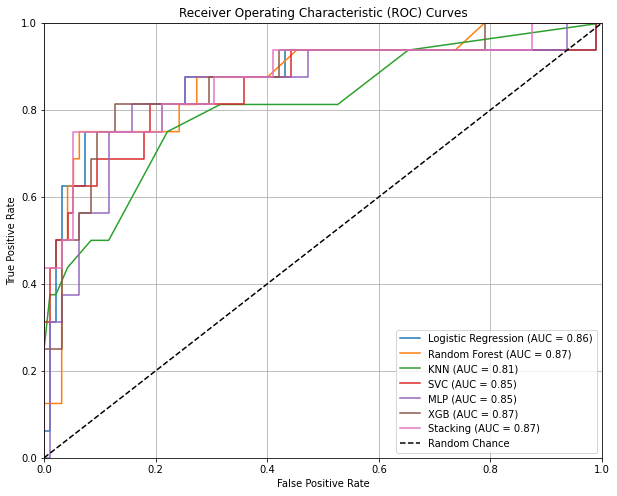

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        95
           1       0.77      0.62      0.69        16

    accuracy                           0.92       111
   macro avg       0.85      0.80      0.82       111
weighted avg       0.91      0.92      0.92       111


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        95
           1       0.67      0.75      0.71        16

    accuracy                           0.91       111
   macro avg       0.81      0.84      0.83       111
weighted avg       0.92      0.91      0.91       111


Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        95
           1       0.86      0.38      0.52        16

    accuracy                           0.90       111
   macr

In [108]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, classification_report

# Initialiser les modèles
models = {
    'Logistic Regression': pipeline_lr,
    'Random Forest': pipeline_rf,
    'KNN': pipeline_knn,
    'SVC': pipeline_svc,
    'MLP': pipeline_mlp,
    'XGB': pipeline_xgb,
    'Stacking': stacking_model
}

# Dictionnaire pour stocker les courbes ROC et les seuils
roc_curves = {}
classification_reports = {}

# Entraîner les modèles et calculer les courbes ROC
for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # Obtenir les probabilités pour la classe positive
    fpr, tpr, thresholds = roc_curve(Y_test, y_prob)  # Calculer la courbe ROC
    roc_auc = auc(fpr, tpr)  # Calculer l'aire sous la courbe
    
    # Calculer le meilleur seuil (maximisation du score F1)
    f1_scores = [f1_score(Y_test, (y_prob >= threshold).astype(int)) for threshold in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    # Prédictions basées sur le meilleur seuil
    y_pred = (y_prob >= best_threshold).astype(int)
    
    # Rapport de classification
    classification_reports[model_name] = classification_report(Y_test, y_pred)
    
    # Stocker les résultats
    roc_curves[model_name] = (fpr, tpr, roc_auc, best_threshold)

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, roc_auc, _) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Tracer la diagonale (chance)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Ajouter des détails au graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Afficher les rapports de classification
for model_name, report in classification_reports.items():
    print(f'Classification Report for {model_name}:\n{report}\n')


#### Conclusion

**Nos prédictions n'ont pas obtenu un score f1 > 80%** comme souhaité malgré plusieurs techniques d'imputation et de feature engineering utilisées sur le training set. Il y avait **beaucoup trop de NaN dans les données** et les méthodes basées sur du fillna sur les variables continues avec la valeur moyenne en fonction de la classe étaient biaisées sur le test set à cause du **manque de données**. Le modèle de staciking avec tous les modèles optimisés généralise bien sur des données nouvelles mais à cause de **la classe 0 majoritaire à 90%**, il y a encore trop de faux négatifs. L'overfitting est présent et il est clair qu'**il faudrait plus de données** de bonne qualité (notamment avec la classe positive) pour améliorer les résultats et avoir une bonne généralisation du modèle. **Un score f1 de 0.73 sur un tel data set est un bon résultat.**

Ce projet a également permis de mettre au point des **pipelines** et des **transformers spéciaux** avec SMOTENC tout en **évitant le data leakage.**